# Cross-Validation and Generalization

In [50]:
# data management
import pandas as pd

# data preprocessing and transformation (ETL)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, FunctionTransformer, Binarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# math and stat modules
import numpy as np
from scipy.stats import sem
from random import choice

# Supervised Learning
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, RepeatedKFold, ShuffleSplit, StratifiedShuffleSplit, learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl

## Data preparation

In [51]:
bank_data = pd.read_csv('data/data_banknote_authentication.txt', delimiter=',', header=None, names=['f1', 'f2', 'f3', 'f4', 'label'])
y = bank_data.pop('label').values
X = bank_data.values
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Cross-validation

Cross-validation methodologies can be used to get more reliable assessment on the generalization of the trained model, i.e. how the model will perform on unseen data.

To prevent data overfitting, i.e. a strong adaptation of the model to the training dataset and the inability to generalize to unseen data, a common practice is the holdout cross-validation.

As usual, the dataset is divided into 2 disjoint sets: the training set and the testing set. The former is used for model training and the latter is for performance evaluation and the final assessment of generalization.


### k-fold cross-validation

In k-fold cross-validation - k-fold CV - the training set is divided into k disjoint sets - fold, such that for each fold f:
1. the remaining k - 1 folds are places as training set
2. the model is trained on k - 1fold and tested on the selected validation fold f.

In short, we get k models and k different performance measures, on which we compute the average performance. Moreover, once we selected the best hyperparameters, we re-trained the model on the entire training set and we evaluate the final model on the original test set.

Through the method cross_val_score we execute k-CV and get the performance for each fold.
Usually, the common practice is to set k equal to 5 or 10, according to the size of the dataset. In SKLearn, if K is an integer KFold or StratifiedKFold (means that the ratio between positive and negative in each fold is the same; useful in case of unbalanced classes) are the default strategies.
KFold is a special case of stratification.

In [52]:
cls = LogisticRegression()
cls_score = cross_val_score(cls, X_train, y_train, cv=5)
cls_score

array([0.9757085 , 0.97975709, 0.97165992, 0.98380567, 0.98780488])

In [53]:
max(cls_score)

0.9878048780487805

The cv parameter accepts different data types, so to specify which splitting strategy will be applied on the training set. In fact, integer, CV objects or indices are allowed.

A method similar to cross_val_score is cross_val_predict. It returns, for each element in the training set, the label predicted by the classifier trained when the element was in the validation fold.

In [54]:
y_predicted = cross_val_predict(cls, X_train, y_train, cv=5)

We now compute the confusion matrix using the prediction returned by cross_val_predict.

In [55]:
confusion_matrix(y_train, y_predicted)

array([[663,  22],
       [  3, 546]])

### Cross-Validation Iterators

The fold generation depends on the partitioning strategy. We assume data is IDD so we can use
- k-fold
- Repeated k-fold (k-fold with number k, we repeat k-folds n times to make evaluation more robust and get more stable results, to have more samples of the performance)
- LOO
- LPO
- Shuffle and Split
Class KFold implements the k-fold splitting on the k-fold CV. 

In [56]:
kf = KFold(n_splits=10)
cls = LogisticRegression()
scores = cross_val_score(cls, X_train, y_train, cv=kf)
scores

array([0.98387097, 0.96774194, 0.97580645, 0.98387097, 1.        ,
       0.94308943, 0.98373984, 0.98373984, 0.98373984, 0.99186992])

In [57]:
max(scores)

1.0

The method split returns the list of training and validation folds for each splitting, expressed in terms of the row-index of the feature matrix. It indicates which rows to put in training folds and which ones to put in the validation fold.

In [58]:
all_cls = []
for train_idx, test_idx in kf.split(X_train, y_train):
    x_train_fold, y_train_fold = X_train[train_idx, :], y_train[train_idx]
    cls = LogisticRegression()
    cls.fit(x_train_fold, y_train_fold)
    print(cls.coef_)
    
    x_val_fold, y_val_fold = X_train[test_idx, :], y_train[test_idx]
    fold_predicted = cls.predict(x_val_fold)
    print(np.sum(fold_predicted == y_val_fold) / len(y_val_fold))
    print('-'*10)
    all_cls.append(cls)
print(all_cls[3])

[[-4.67509174 -4.68970131 -4.28127757  0.18094883]]
0.9838709677419355
----------
[[-4.7348513  -4.63288787 -4.26076542  0.23280111]]
0.967741935483871
----------
[[-4.72105199 -4.57835292 -4.24705968  0.22280269]]
0.9758064516129032
----------
[[-4.71519906 -4.65042115 -4.24333667  0.18160744]]
0.9838709677419355
----------
[[-4.71701976 -4.67469707 -4.29794712  0.16592423]]
1.0
----------
[[-4.70181284 -4.70373053 -4.25965372  0.20177336]]
0.943089430894309
----------
[[-4.7882071  -4.61147494 -4.24706792  0.25694667]]
0.983739837398374
----------
[[-4.71348162 -4.70476368 -4.31840781  0.20097281]]
0.983739837398374
----------
[[-4.71525493 -4.57500224 -4.27662115  0.20932435]]
0.983739837398374
----------
[[-4.69067019 -4.70845599 -4.30606312  0.17596107]]
0.991869918699187
----------
LogisticRegression()


In [59]:
cls_all = LogisticRegression()
cls_all.fit(X_train, y_train)
print(cls_all.predict(X_test)[:10], y_train[:10])

[1 0 1 1 0 1 1 0 1 0] [0 0 1 1 0 0 1 0 1 0]


To reduce the oscillations in the performance measurements we can repeat k-fold CV many times and return the average performance over all the folds and all the repetitions.
This approach can be applied  to small/medium size datasets because it is computationally expensive even if we run it in parallel.
SKL provides such method by the class RepeatedKFold. The required parameters are K and n_repeats, the number of repetitions.

In [60]:
rkf = RepeatedKFold(n_splits=10, n_repeats=3)
cross_val_score(cls, X_train, y_train, cv=rkf)

array([0.97580645, 1.        , 0.97580645, 0.98387097, 0.98373984,
       0.98373984, 0.97560976, 0.98373984, 0.96747967, 0.96747967,
       0.98387097, 0.98387097, 0.9516129 , 0.96774194, 0.98373984,
       0.98373984, 0.98373984, 0.98373984, 1.        , 0.97560976,
       0.93548387, 0.96774194, 0.98387097, 1.        , 0.99186992,
       0.96747967, 0.99186992, 0.97560976, 0.97560976, 1.        ])

Through the parameter n_jobs we select the number of cores for parallel execution.

{'whiskers': [<matplotlib.lines.Line2D at 0x12ee1f320>,
 'caps': [<matplotlib.lines.Line2D at 0x12ee1faa0>,
 'boxes': [<matplotlib.lines.Line2D at 0x12ee1f1a0>,
 'medians': [<matplotlib.lines.Line2D at 0x12ee1c110>,
 'fliers': [<matplotlib.lines.Line2D at 0x12ee1c4a0>,
 'means': [<matplotlib.lines.Line2D at 0x12ee1c350>,
  <matplotlib.lines.Line2D at 0x12f4a4620>]}

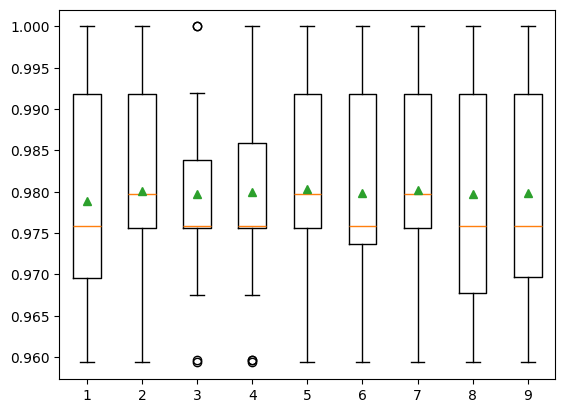

In [61]:
def eval_model_repetition(X, y, repeats):
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    cls = Perceptron()
    scores = cross_val_score(cls, X, y, cv=cv, n_jobs=-1)
    return scores

repeats = range(1, 10)
results = list()
for i in repeats:
    scores = eval_model_repetition(X_train, y_train, i)
    results.append(scores)
plt.boxplot(results, labels=[str(i) for i in repeats], showmeans=True)

### Stratification

In the case the class distribution is unbalanced, we have to apply stratified sampling, implemented by the classes StratifiedKFold and StratifiedShuffleSplit. It is guaranteed that the class distribution of each fold is similar the class distribution of the entire target vector.

In [62]:
kf = KFold(n_splits=10)
skf = StratifiedKFold(n_splits=10)
print('----K-fold CV----------------')

for train, test in kf.split(X, y):
    y_train_split, y_test_split = y[train], y[test]
    print('Train: {:2f} vs Test: {:2f}'.format(sum(y_train_split == 1) / len(y_train_split), sum(y_test_split == 1) / len(y_test_split)))
print('----Stratified K-fold CV--------------')
for train, test in skf.split(X, y):
    y_train_split, y_test_split = y[train], y[test]
    print('Train: {:2f} vs Test: {:2f}'.format(sum(y_train_split == 1) / len(y_train_split), sum(y_test_split == 1) / len(y_test_split)))

----K-fold CV----------------
Train: 0.494327 vs Test: 0.000000
Train: 0.494327 vs Test: 0.000000
Train: 0.493927 vs Test: 0.000000
Train: 0.493927 vs Test: 0.000000
Train: 0.493927 vs Test: 0.000000
Train: 0.443725 vs Test: 0.452555
Train: 0.382996 vs Test: 1.000000
Train: 0.382996 vs Test: 1.000000
Train: 0.382996 vs Test: 1.000000
Train: 0.382996 vs Test: 1.000000
----Stratified K-fold CV--------------
Train: 0.444895 vs Test: 0.442029
Train: 0.444895 vs Test: 0.442029
Train: 0.444534 vs Test: 0.445255
Train: 0.444534 vs Test: 0.445255
Train: 0.444534 vs Test: 0.445255
Train: 0.444534 vs Test: 0.445255
Train: 0.444534 vs Test: 0.445255
Train: 0.444534 vs Test: 0.445255
Train: 0.444534 vs Test: 0.445255
Train: 0.444534 vs Test: 0.445255


### Learning and Validation curve

Learning and validation curves represent useful tools for identifying issues related to overfitting or underfitting.

If a model is too complex, we will expect overfitting and low generalization power. in this case, increasing the size of the training set. Indeed, we can report the accuracy of the model on the training and validation set as a function of the size of the training set, obtaining the learning curve.

In SKLearn we get all the elements for computing the learning curve through the method learning_curve.

We increase the number of training samples and we run cross-validation on each subset of the original training sample.
We hope that 2 lines converge.

In [63]:
logit_cls = LogisticRegression(max_iter=1000)

In [64]:
train_sizes, train_scores, test_scores = learning_curve(logit_cls, # classifier, i.e. the model we want to evaluate
                                                       X=X_train, 
                                                       y=y_train,
                                                       train_sizes=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                                                       cv=10,
                                                       n_jobs=-1, # to enforce parallelism
                                                       shuffle=False) # we don't want shuffling

/Users/aleksandrak/Desktop/ML-course-Labs/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
1 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/aleksandrak/Desktop/ML-course-Labs/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aleksandrak/Desktop/ML-course-Labs/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ale

The most important parameters are train_size and cv.
- train_sizes: the portion of the original X_Train to be maintained.
- cv: cross-validation (K-Fold)

In [65]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

(0.87, 1.03)

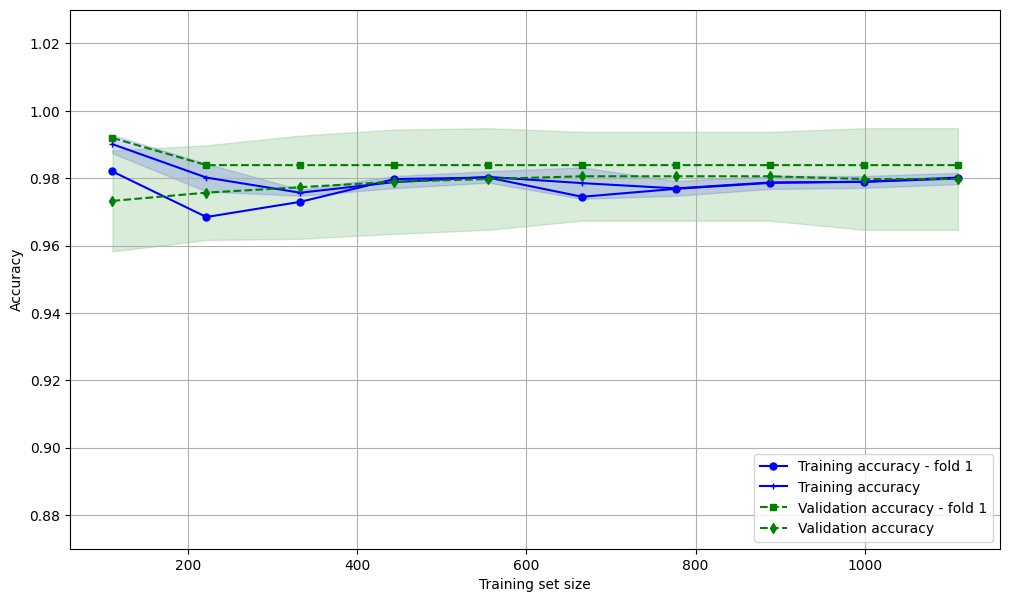

In [66]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot()
ax.plot(train_sizes, train_scores[:, 0],
        color='blue', marker='o',
        markersize=5, label='Training accuracy - fold 1')
ax.plot(train_sizes, train_mean,
        color='blue', marker='+',
        markersize=5, label='Training accuracy')
ax.fill_between(train_sizes, train_mean + train_std, 
                train_mean - train_std, alpha=0.15, color='blue')
ax.plot(train_sizes, test_scores[:, 0],
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='Validation accuracy - fold 1')
ax.plot(train_sizes, test_mean,
        color='green', linestyle='--',
        marker='d', markersize=5,
        label='Validation accuracy')
ax.fill_between(train_sizes, test_mean + test_std, 
                test_mean - test_std, alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')
ax.set_ylim([0.87, 1.03])

- Low variance in the accuracy -> it's very stable.
- On average there's no oferfitting, but algorithms is not very stable, the validation is higher than the training set.

In [67]:
train_sizes[0]

11

Another tool for evaluating issues related to over-/under-fitting is the validation curve. In this case we vary the hyperparameters of the model.
For LogisticRegression, the parameter C is the inverse of the regularization parameter lambda, so that by increasing C we reduce the regularization.
In SKL we get all the elements for computing the validation curve through the method validation_curve.

In [68]:
range_C = [0.001, 0.01, 0.1, 1, 10, 100]
train_scores, test_scores = validation_curve(logit_cls, X=X_train, y=y_train,
                                             param_range=range_C, param_name='C', # we have to specify the name of the parameter
                                             cv=10, n_jobs=-1)

In [69]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

(0.0, 1.03)

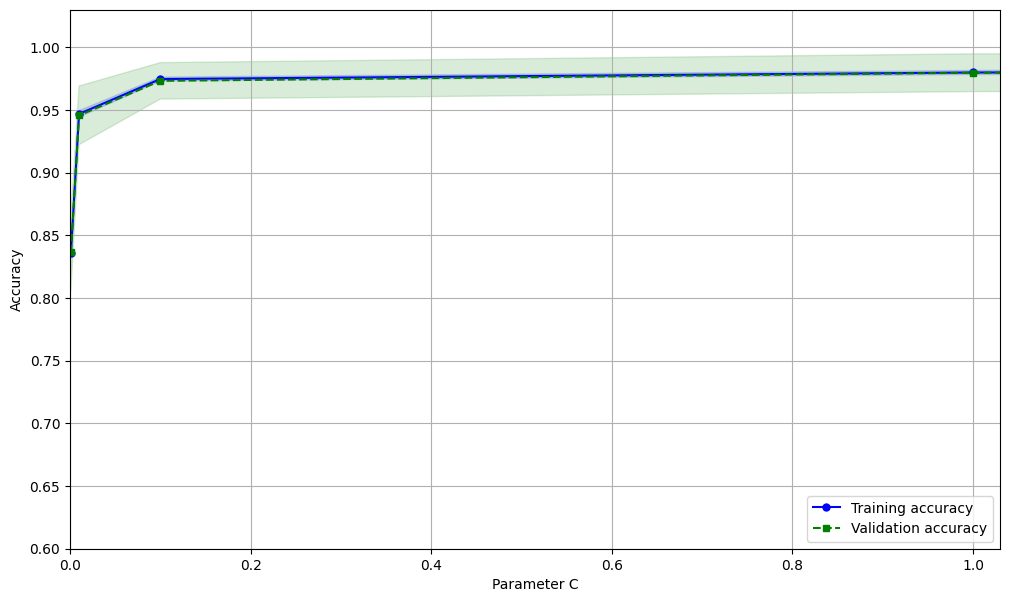

In [70]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot()

ax.plot(range_C, train_mean,
        color='blue', marker='o',
        markersize=5, label='Training accuracy')

ax.fill_between(range_C, train_mean + train_std, 
                train_mean - train_std, alpha=0.15, color='blue')

ax.plot(range_C, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='Validation accuracy')

ax.fill_between(range_C, test_mean + test_std, 
                test_mean - test_std, alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter C')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')
ax.set_ylim([0.6, 1.03])
ax.set_xlim([0., 1.03])

There is no effect on overfitting, i.e. in terms of overfitting we can take C randomly. We will take 1.0 since we have the best result.